In [ ]:
#hide
#skip
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab

In [ ]:
# default_exp interpret

In [ ]:
#export
from fastai.data.all import *
from fastai.optimizer import *
from fastai.learner import *
import sklearn.metrics as skm

In [ ]:
#hide
from fastai.test_utils import *

# Interpretation of Predictions

> Classes to build objects to better interpret predictions of a model

In [ ]:
#hide
from fastai.vision.all import *
mnist = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock), 
                  get_items=get_image_files, 
                  splitter=RandomSubsetSplitter(.1,.1, seed=42),
                  get_y=parent_label)
test_dls = mnist.dataloaders(untar_data(URLs.MNIST_SAMPLE), bs=8)
test_learner = cnn_learner(test_dls, resnet18)

In [ ]:
#export
@typedispatch
def plot_top_losses(x, y, *args, **kwargs):
    raise Exception(f"plot_top_losses is not implemented for {type(x)},{type(y)}")

In [ ]:
#export
_all_ = ["plot_top_losses"]

In [ ]:
#export
class Interpretation():
    "Interpretation base class, can be inherited for task specific Interpretation classes"
    def __init__(self, dl, inputs, preds, targs, decoded, losses):
        store_attr("dl,inputs,preds,targs,decoded,losses")

    @classmethod
    def from_learner(cls, learn, ds_idx=1, dl=None, act=None):
        "Construct interpretation object from a learner"
        if dl is None: dl = learn.dls[ds_idx].new(shuffled=False, drop_last=False)
        return cls(dl, *learn.get_preds(dl=dl, with_input=True, with_loss=True, with_decoded=True, act=None))

    def top_losses(self, k=None, largest=True):
        "`k` largest(/smallest) losses and indexes, defaulting to all losses (sorted by `largest`)."
        return self.losses.topk(ifnone(k, len(self.losses)), largest=largest)

    def plot_top_losses(self, k, largest=True, **kwargs):
        losses,idx = self.top_losses(k, largest)
        if not isinstance(self.inputs, tuple): self.inputs = (self.inputs,)
        if isinstance(self.inputs[0], Tensor): inps = tuple(o[idx] for o in self.inputs)
        else: inps = self.dl.create_batch(self.dl.before_batch([tuple(o[i] for o in self.inputs) for i in idx]))
        b = inps + tuple(o[idx] for o in (self.targs if is_listy(self.targs) else (self.targs,)))
        x,y,its = self.dl._pre_show_batch(b, max_n=k)
        b_out = inps + tuple(o[idx] for o in (self.decoded if is_listy(self.decoded) else (self.decoded,)))
        x1,y1,outs = self.dl._pre_show_batch(b_out, max_n=k)
        if its is not None:
            plot_top_losses(x, y, its, outs.itemgot(slice(len(inps), None)), L(self.preds).itemgot(idx), losses,  **kwargs)
        #TODO: figure out if this is needed
        #its None means that a batch knows how to show itself as a whole, so we pass x, x1
        #else: show_results(x, x1, its, ctxs=ctxs, max_n=max_n, **kwargs)

In [ ]:
#hide
interp = Interpretation.from_learner(test_learner)
x, y, out = [], [], []
for batch in test_learner.dls.valid:
    x += batch[0]
    y += batch[1]
    out += test_learner.model(batch[0])
x,y,out = torch.stack(x), torch.stack(y, dim=0), torch.stack(out, dim=0)
test_eq(interp.inputs, to_cpu(x))
test_eq(interp.targs, to_cpu(y))
losses = torch.stack([test_learner.loss_func(p,t) for p,t in zip(out,y)], dim=0)
test_close(interp.losses, to_cpu(losses))

In [ ]:
#hide
#dummy test to ensure we can run on the training set
interp = Interpretation.from_learner(test_learner, ds_idx=0)
x, y, out = [], [], []
for batch in test_learner.dls.train.new(drop_last=False, shuffle=False):
    x += batch[0]
    y += batch[1]
    out += test_learner.model(batch[0])
x,y,out = torch.stack(x), torch.stack(y, dim=0), torch.stack(out, dim=0)
test_eq(interp.inputs, to_cpu(x))
test_eq(interp.targs, to_cpu(y))
losses = torch.stack([test_learner.loss_func(p,t) for p,t in zip(out,y)], dim=0)
test_close(interp.losses, to_cpu(losses))

In [ ]:
#export
class ClassificationInterpretation(Interpretation):
    "Interpretation methods for classification models."

    def __init__(self, dl, inputs, preds, targs, decoded, losses):
        super().__init__(dl, inputs, preds, targs, decoded, losses)
        self.vocab = self.dl.vocab
        if is_listy(self.vocab): self.vocab = self.vocab[-1]

    def confusion_matrix(self):
        "Confusion matrix as an `np.ndarray`."
        x = torch.arange(0, len(self.vocab))
        d,t = flatten_check(self.decoded, self.targs)
        cm = ((d==x[:,None]) & (t==x[:,None,None])).long().sum(2)
        return to_np(cm)

    def plot_confusion_matrix(self, normalize=False, title='Confusion matrix', cmap="Blues", norm_dec=2,
                              plot_txt=True, **kwargs):
        "Plot the confusion matrix, with `title` and using `cmap`."
        # This function is mainly copied from the sklearn docs
        cm = self.confusion_matrix()
        if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fig = plt.figure(**kwargs)
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        tick_marks = np.arange(len(self.vocab))
        plt.xticks(tick_marks, self.vocab, rotation=90)
        plt.yticks(tick_marks, self.vocab, rotation=0)

        if plot_txt:
            thresh = cm.max() / 2.
            for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
                coeff = f'{cm[i, j]:.{norm_dec}f}' if normalize else f'{cm[i, j]}'
                plt.text(j, i, coeff, horizontalalignment="center", verticalalignment="center", color="white" if cm[i, j] > thresh else "black")

        ax = fig.gca()
        ax.set_ylim(len(self.vocab)-.5,-.5)

        plt.tight_layout()
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.grid(False)

    def most_confused(self, min_val=1):
        "Sorted descending list of largest non-diagonal entries of confusion matrix, presented as actual, predicted, number of occurrences."
        cm = self.confusion_matrix()
        np.fill_diagonal(cm, 0)
        res = [(self.vocab[i],self.vocab[j],cm[i,j])
                for i,j in zip(*np.where(cm>=min_val))]
        return sorted(res, key=itemgetter(2), reverse=True)

    def print_classification_report(self):
        "Print scikit-learn classification report"
        d,t = flatten_check(self.decoded, self.targs)
        print(skm.classification_report(t, d, labels=list(self.vocab.o2i.values()), target_names=[str(v) for v in self.vocab]))

In [ ]:
#export
class SegmentationInterpretation(Interpretation):
    "Interpretation methods for segmentation models."
    pass

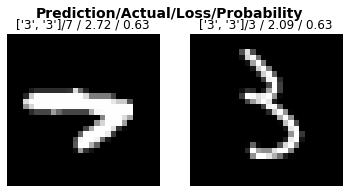

In [ ]:
#hide
#ensure Interpretation.plot_top_losses works on problems with multiple outputs

mnist = DataBlock((ImageBlock, CategoryBlock, CategoryBlock), get_items=get_image_files,
                   splitter=RandomSubsetSplitter(.1,.1, seed=42),
                   n_inp=1,
                   get_y=[parent_label, parent_label])
test_dls = mnist.dataloaders(untar_data(URLs.MNIST_SAMPLE), bs=8)

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = create_cnn_model(resnet18, get_c(test_dls)[0])
        
    def forward(self, x):
        return self.backbone(x), self.backbone(x)
    
def loss(inputs, targeta, targetb, reduction="mean"):
    loss1 = CrossEntropyLossFlat(reduction=reduction)(inputs[0], targeta)
    loss2 = CrossEntropyLossFlat(reduction=reduction)(inputs[1], targetb)
    return loss1 + loss2

@typedispatch
def plot_top_losses(x: TensorImage, y: tuple, *args, **kwargs):
    plot_top_losses(x, y[0], *args, **kwargs)

test_learner = Learner(test_dls, Model(), loss_func=loss)
interp = Interpretation.from_learner(test_learner)
interp.plot_top_losses(2)

## Export -

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_torch_core.ipynb.
Converted 01_layers.ipynb.
Converted 01a_losses.ipynb.
Converted 02_data.load.ipynb.
Converted 03_data.core.ipynb.
Converted 04_data.external.ipynb.
Converted 05_data.transforms.ipynb.
Converted 06_data.block.ipynb.
Converted 07_vision.core.ipynb.
Converted 08_vision.data.ipynb.
Converted 09_vision.augment.ipynb.
Converted 09b_vision.utils.ipynb.
Converted 09c_vision.widgets.ipynb.
Converted 10_tutorial.pets.ipynb.
Converted 10b_tutorial.albumentations.ipynb.
Converted 11_vision.models.xresnet.ipynb.
Converted 12_optimizer.ipynb.
Converted 13_callback.core.ipynb.
Converted 13a_learner.ipynb.
Converted 13b_metrics.ipynb.
Converted 14_callback.schedule.ipynb.
Converted 14a_callback.data.ipynb.
Converted 15_callback.hook.ipynb.
Converted 15a_vision.models.unet.ipynb.
Converted 16_callback.progress.ipynb.
Converted 17_callback.tracker.ipynb.
Converted 18_callback.fp16.ipynb.
Converted 18a_callback.training.ipynb.
Converted 18b_callback.preds.ipynb.
Converted 